In [55]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

In [57]:
#load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((76020, 371), (75818, 370))

In [58]:
# Add feature with sum of zero values per rows

# train set
X = train.iloc[:,:-1]
y = train.TARGET

X['no0'] = (X==0).sum(axis=1)
train['no0'] = X['no0']

# test set
X = test.iloc[:,:]
X['no0'] = (X==0).sum(axis=1)
test['no0'] = X['no0']

In [59]:
# remove columns with 0 variance
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

len(remove)

34

In [60]:
train.drop(remove, axis = 1, inplace=True)
test.drop(remove, axis = 1, inplace=True)

In [61]:
# remove duplicated columns
dup_cols = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1, len(cols)):
        if np.array_equal(v, train[cols[j]].values):
            dup_cols.append(cols[j])
            
len(dup_cols)

29

In [62]:
train.drop(dup_cols, axis=1, inplace = True)
test.drop(dup_cols, axis=1, inplace=True)

In [63]:
train.shape, test.shape

((76020, 309), (75818, 308))

In [64]:
# split data into training and testing set
test_id = test.ID
test.drop(['ID'], axis= 1, inplace=True)

X = train.drop(['TARGET', 'ID'], axis=1)
y = train.TARGET.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1729 )

In [65]:
X.shape, test.shape

((76020, 307), (75818, 307))

In [66]:
## Feature selection
clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

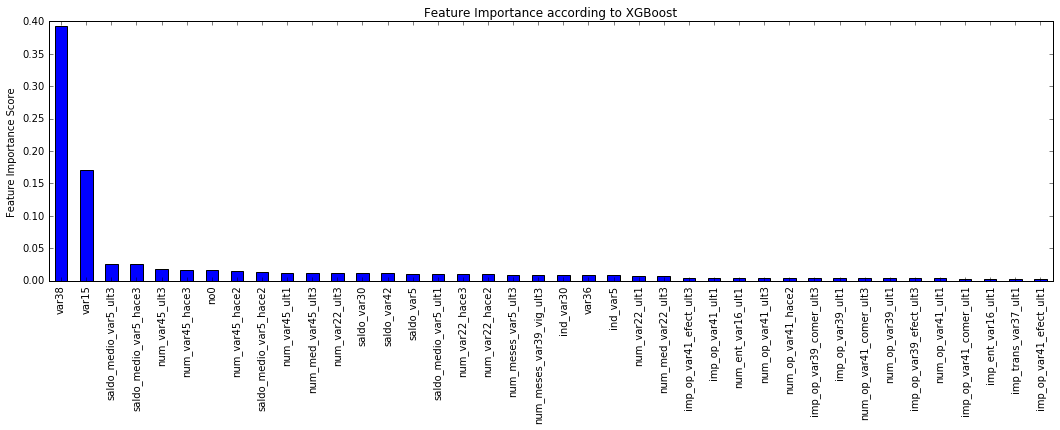

In [67]:
# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values)
feat_imp = feat_imp.sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title = 'Feature Importance according to XGBoost')
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom = 0.3)

fig = plt.gcf()
fig.set_size_inches(18, 6)

In [68]:
feat_imp.head()

var38                     0.393154
var15                     0.169927
saldo_medio_var5_ult3     0.025693
saldo_medio_var5_hace3    0.025365
num_var45_ult3            0.018504
dtype: float64

In [69]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [70]:
X_train.shape, X_test.shape, test.shape

((60816, 32), (15204, 32), (75818, 307))

In [71]:
## Model 1: Train Model

# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

Roc AUC test:  0.830484959049
Roc AUC train:  0.872230973963


In [72]:
## Second Model, with 40 features selected from ExtraTrees Classifier
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

vars_to_keep = feat_imp.index.values[0:40]
vars_to_keep = list(vars_to_keep)

X_train, X_test, y_train, y_test = train_test_split(train[vars_to_keep], y, test_size=0.2,
                                                    random_state=1729 )

# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

Roc AUC test:  0.829305525603
Roc AUC train:  0.872912575629


In [73]:
## Third Model, with features selected from small Boruta Classifier
boruta_vars = ['var15', 'num_var37_med_ult2', 'num_var37_0', 'saldo_var5', 'saldo_var30', 'saldo_var37', 'saldo_var42',
               'num_var22_hace3', 'num_var22_ult3', 'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_var45_hace2',
               'num_var45_hace3', 'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3',
               'no0']

X_train, X_test, y_train, y_test = train_test_split(train[boruta_vars], y, test_size=0.2,
                                                    random_state=1729 )

# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

Roc AUC test:  0.82170993446
Roc AUC train:  0.859168066531


In [74]:
## Fourth Model, with features selected from small Boruta + ExtraTrees Classifier
vars_to_keep = feat_imp.index.values[0:32]
vars_to_keep = list(vars_to_keep)

diff_vars =[]
for var in boruta_vars:
    if var not in vars_to_keep:
        diff_vars.append(var)
        
diff_vars

['num_var37_med_ult2', 'num_var37_0', 'saldo_var37']

In [75]:
for var in diff_vars:
    vars_to_keep.append(var)

len(vars_to_keep)

35

In [76]:
X_train, X_test, y_train, y_test = train_test_split(train[vars_to_keep], y, test_size=0.2,
                                                    random_state=1729 )

# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

Roc AUC test:  0.830456083303
Roc AUC train:  0.873007348683


In [78]:
## Fifth Model, with features selected from big Boruta Classifier
boruta_big_vars = vars_to_keep = ['var38','var15','imp_op_var39_comer_ult3','imp_op_var41_comer_ult3',
                'imp_op_var41_efect_ult1','imp_op_var41_efect_ult3','imp_op_var41_ult1',
                'imp_op_var39_efect_ult1','imp_op_var39_efect_ult3','imp_op_var39_ult1',
                'ind_var37_cte','ind_var37_0', 'num_op_var41_hace2','num_op_var41_ult1',
                'num_op_var41_ult3','num_op_var39_ult1','num_op_var39_ult3','num_var37_med_ult2',
                'num_var37_0', 'saldo_var5', 'saldo_var30', 'saldo_var37', 'saldo_var42', 'num_var22_hace2',
                'num_var22_hace3', 'num_var22_ult3', 'num_med_var22_ult3', 'num_med_var45_ult3', 'num_meses_var5_ult3',
                'num_op_var39_comer_ult1','num_op_var39_comer_ult3', 'num_op_var41_comer_ult1', 'num_op_var41_comer_ult3',
                'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1', 'num_var45_ult3', 'saldo_medio_var5_hace2',
                'saldo_medio_var5_ult1','saldo_medio_var5_ult3', 'no0']

X_train, X_test, y_train, y_test = train_test_split(train[boruta_big_vars], y, test_size=0.2,
                                                    random_state=1729 )

# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

Roc AUC test:  0.829386576455
Roc AUC train:  0.872121075796


In [ ]:
## # Submission
probs = m2_xgb.predict_proba(test[boruta_big_vars])

submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})
submission.to_csv("submission_1.csv", index=False)

### For each selected:

1) Generate 4 binary variables segregated by quartiles.

2) Generate the log transformation.

3) Select the best of the 6 against the target variable, and drop the rest.

In [ ]:
# categorisation by quantiles + add log transformation
def feat_eng(col, data):
    a = False
    try:
        temp = pd.qcut(data[col], [0, .25, .5, .75, 1], labels = ['FirstQ','SecondQ','ThirdQ','FourthQ'])
        temp_dummies = pd.get_dummies(temp)
        a = True
    except:
        pass
    
    if a:
        temp_dummies['log'] = np.log(data[col]+1)
        temp_dummies['asis'] = data[col]
    else:
        temp_dummies = pd.DataFrame(index=data.index, columns= ['asis', 'log'])
        temp_dummies['log'] = np.log(data[col]+1)
        temp_dummies['asis'] = data[col]
        
    return temp_dummies

In [ ]:
# feature selection function
def check_features(Y,features):
    X_train, X_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.2, random_state=42)
    clf = ExtraTreesClassifier(random_state=1729)
    selector = clf.fit(X_train, y_train)
    
    feat_imp = pd.Series(clf.feature_importances_, index = features.columns.values)
    feat_imp = feat_imp.sort_values(ascending=False)
    #selector = SelectKBest(f_regression, k = 1)
    #selector.fit(X_train, Y_train)
    
    return feat_imp.index[0]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_sm = train[boruta_big_vars]
test_sm = test[boruta_big_vars]

for col in boruta_big_vars:
    var = feat_eng(col, train_sm)
    var.log.fillna(var.log.mean(), inplace = True)

    temp = check_features(y,var)
    col_name = col + '_' + temp
    train_sm[col_name] = var[temp]
    train_sm.drop(col, axis = 1, inplace = True)
    
    # for the test set
    var = feat_eng(col, test_sm)
    var.log.fillna(var.log.mean(), inplace = True)
    test_sm[col_name] = var[temp]
    test_sm.drop(col, axis = 1, inplace = True)

In [ ]:
# Sixth Model

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(train_sm, y, test_size=0.2,
                                                    random_state=1729 )

## # Train Model
# classifier from xgboost
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])

print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))

In [ ]:
## Model Optimisation
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import RandomizedSearchCV

xgbparams = {'learning_rate' : 0.1, 
                     'n_estimators': 50,
                     'max_depth': 5,
                     'min_child_weight': 1,
                     'gamma': 0,
                     'subsample': 0.8,
                     'colsample_bytree': 0.8,
                     'objective' : 'binary:logistic',
                     'nthread': 4,
                     'scale_pos_weight': 1,
                     'seed' : 27}

# split data into training and testing set (smaller train set so it doesn't take forever)
X_train, X_test, y_train, y_test = train_test_split(train[boruta_big_vars], y, test_size=0.8,
                                                    random_state=1729 )

xgb_model = XGBClassifier(xgbparams, nthread=-1)

clf = RandomizedSearchCV(
    xgb_model,
    {
        'max_depth': [1,3,5,7,9],
        'min_child_weight':[1,3,5,7],
        'subsample':[i/10 for i in range(6,10)],
        'colsample_bytree':[i/10 for i in range(6,10)],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
        'learning_rate':[0.01, 0.03, 0.1, 0.3, 1],
        'n_estimators':[10, 100, 500, 1000],
        'gamma':[0.01,0.1,1,10]
    },
    cv=5,
    verbose=0,
    n_jobs=1,
    scoring = 'roc_auc'
)

clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
#final model with the optimised parameters (copy from the above solution)
X_train, X_test, y_train, y_test = train_test_split(train[boruta_big_vars], y, test_size=0.2,
                                                    random_state=1729)

m2_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.03, max_depth = 7, min_child_weight =5,
                           subsample = 0.6, colsample_bytree=0.9, reg_alpha= 0.01, gamma=0.1,
                           nthread=4, seed=1729)

m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False,
           eval_set=[(X_test, y_test)])


print("Roc AUC test: ", roc_auc_score(y_test, m2_xgb.predict_proba(X_test)[:,1],
              average='macro'))

print("Roc AUC train: ", roc_auc_score(y_train, m2_xgb.predict_proba(X_train)[:,1],
              average='macro'))